Train model and generate trained models performace summary.  
Models are ordered by validation performace from good to bad

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from vol_predict import VolPredictor
from sklearn.model_selection import train_test_split

In [2]:
# Momentum refers to the rate of change in price movement over a period of time to help determine the strength of a trend
def calculate_momentum(price_data, window):
    momentum = (price_data / price_data.shift(window) - 1) * 100
    return momentum

In [3]:
# Average True Range is a technical indicator that measures market volatility by calculating the average range of price movement
def calculate_average_true_range(price_data, window):
    current_high_low = price_data['High'] - price_data['Low']
    high_prev_close = abs(price_data['High'] - price_data['Close'].shift(1))
    low_prev_close = abs(price_data['Low'] - price_data['Close'].shift(1))
    tr = pd.concat([current_high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)

    atr = tr.rolling(window).mean()
    return atr

In [4]:
# The moving range of close priced during a period time calculated based on average price and corresponding standard deviation 
def calculate_bollinger_band_width(price_data, window, std_dev):
    middle_band = price_data['Close'].rolling(window).mean()
    upper_band = middle_band + price_data['Close'].rolling(window).std() * std_dev
    lower_band = middle_band - price_data['Close'].rolling(window).std() * std_dev

    BB_width = (upper_band - lower_band) / middle_band * 100
    return BB_width

In [5]:
def calculate_relative_strength_index(price_data, window):
    """
    Calculate the Relative Strength Index (RSI) for a given price series.
    
    Parameters:
        prices (array-like): List or array of closing prices
        window (int): The lookback window for RSI calculation 
    
    Returns:
        array: RSI values
    """
    delta = price_data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window, ).mean()
    avg_loss = loss.rolling(window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [ ]:
def generate_features(origin_data_df:pd.DataFrame):
    
    # Historical Volatility Features
    origin_data_df.loc[:,'Avg_Volume_21D'] = origin_data_df['Volume'].rolling(window=21).mean()
    origin_data_df.loc[:,'Avg_Volume_10D'] = origin_data_df['Volume'].rolling(window=10).mean()
    origin_data_df.loc[:,'Avg_Volume_5D'] = origin_data_df['Volume'].rolling(window=5).mean()
    origin_data_df.loc[:,'Volume_Change_Percentage'] = (origin_data_df['Volume'] - origin_data_df['Avg_Volume_21D']) / origin_data_df['Avg_Volume_21D']
    origin_data_df.loc[:, 'Volume_Skew_21D'] = origin_data_df['Volume'].rolling(window=21).skew()
    origin_data_df.loc[:,'Volume_Skew_10D'] = origin_data_df['Volume'].rolling(window=10).skew()
    origin_data_df.loc[:,'Volume_Skew_5D'] = origin_data_df['Volume'].rolling(window=5).skew()

    # Price_based
    origin_data_df.loc[:, 'Momentum_21D'] = calculate_momentum(origin_data_df[['Close']], 21)
    origin_data_df.loc[:, 'Momentum_10D'] = calculate_momentum(origin_data_df[['Close']], 10)
    origin_data_df.loc[:, 'Momentum_5D'] = calculate_momentum(origin_data_df[['Close']], 5)

    origin_data_df.loc[:, 'ATR_21D'] = calculate_average_true_range(origin_data_df[['High', 'Low', 'Close']], 21)
    origin_data_df.loc[:, 'ATR_14D'] = calculate_average_true_range(origin_data_df[['High', 'Low', 'Close']], 14)
    origin_data_df.loc[:, 'ATR_5D'] = calculate_average_true_range(origin_data_df[['High', 'Low', 'Close']], 5)

    origin_data_df.loc[:, 'BB_Width_21D'] = calculate_bollinger_band_width(origin_data_df[['Close']], 21, 1.5)
    origin_data_df.loc[:, 'BB_Width_10D'] = calculate_bollinger_band_width(origin_data_df[['Close']], 10, 1.5)
    origin_data_df.loc[:, 'BB_Width_5D'] = calculate_bollinger_band_width(origin_data_df[['Close']], 5, 1.5)

    origin_data_df.loc[:, 'RSI_21D'] = calculate_relative_strength_index(origin_data_df[['Close']], 21)
    origin_data_df.loc[:, 'RSI_10D'] = calculate_relative_strength_index(origin_data_df[['Close']], 10)
    origin_data_df.loc[:, 'RSI_5D'] = calculate_relative_strength_index(origin_data_df[['Close']], 5)

    return origin_data_df

In [ ]:
ticker = 'GLD'
DAYS_WINDOW_SIZE = 21
RETRIEVE_PERIOD = '5y'
SEQUENCE_LENGTH_WINDOWS = 6
TARGET_STEPS = 1

model_path = f'./vol_output/vol_lstm_{datetime.today().date()}.keras'
scaler_path = './vol_output/scaler.pkl'

predictor = VolPredictor()

market_data = predictor.get_market_data(ticker, retrieve_period=RETRIEVE_PERIOD)

if len(market_data) == 0:
    print('WARNING: There is no market data retrieved')
    
vol_data = predictor.calculate_return(market_data)

num_cols_before = len(vol_data.columns)
# History Volatility
col_name = f'{predictor._VCOL_PREFIX}_{DAYS_WINDOW_SIZE}'
vol_data.loc[:,col_name] = vol_data['Log_Returns'].rolling(window=DAYS_WINDOW_SIZE).std() * np.sqrt(252) # annulise daily volatility
vol_data = generate_features(vol_data)
vol_data = vol_data.iloc[DAYS_WINDOW_SIZE:]
num_cols_after = len(vol_data.columns)

num_scale_cols = num_cols_after - num_cols_before

col_names = list(vol_data.columns[-num_scale_cols:])
scaled_vol_data = predictor.normalise_data(vol_data, cols=col_names)

feature_cols = ['Date'] + [col for col in scaled_vol_data.columns if col.startswith(predictor._FEATURE_PREFIX)]
feature_data_array = scaled_vol_data[feature_cols].values
X_all_date, y_all_date = predictor.restruncture_data(feature_data_array, vol_window_days=DAYS_WINDOW_SIZE, sequence_months=SEQUENCE_LENGTH_WINDOWS, target_steps=TARGET_STEPS)

# Remove features after volatility. Only leave Date and Scaled Vol
y_all_date = y_all_date[:, :2]

X_train_val_date, X_test_date, y_train_val_date, y_test_date = train_test_split(X_all_date, y_all_date, test_size=0.25, random_state=42) 

# Features: Date - removing from data. 
X_train_val = X_train_val_date[:,:,1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, len(col_names))
y_train_val = y_train_val_date[:, 1].astype(np.float64).reshape(-1, 1)

tuner = predictor.train_model(X_train_val, y_train_val, model_path=model_path)

joblib.dump(predictor.scaler, scaler_path)


Trial 20 Complete [00h 01m 18s]
multi_objective: 0.0036866688169538975

Best multi_objective So Far: 0.0030092319939285517
Total elapsed time: 00h 34m 26s


['./vol_output/scaler.pkl']

In [7]:
print(f'number of test samples: {len(X_test_date)}')
length_all = len(X_all_date)
print(f'number of all samples: {length_all}')
print(f'number of test samples: {length_all - len(X_test_date)}')

number of test samples: 278
number of all samples: 1109
number of test samples: 831


35/35 [==============================] - 1s 19ms/step - loss: 0.0159 - smape: 35.4006


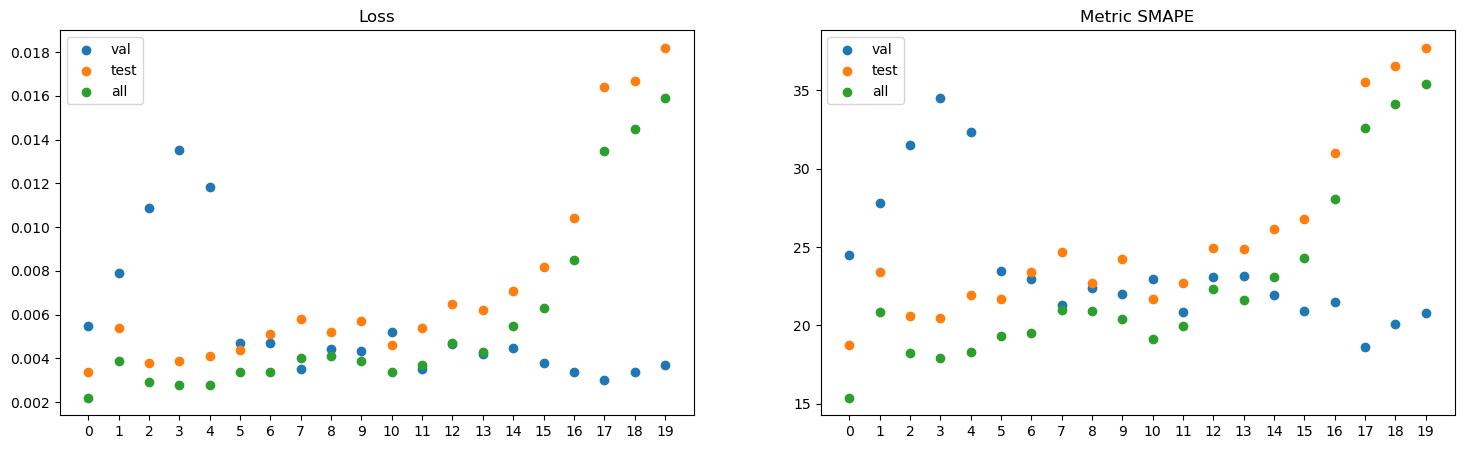

In [ ]:
# Different trainded model performance

# Get all trained trials and models
trials = tuner.oracle.trials
models = tuner.get_best_models(num_models=len(trials))

trial_performance_df = predictor.generate_model_performance(trials, models, 
                                                            X_test=X_test_date[:, :, 1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, len(col_names)),
                                                             y_test=y_test_date[:,1].astype(np.float64).reshape(-1, 1), 
                                                             X_all=X_all_date[:, :, 1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, len(col_names)), 
                                                             y_all=y_all_date[:,1].astype(np.float64).reshape(-1, 1))
trial_performance_df

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

axs[0].scatter(y=trial_performance_df['score'], x=trial_performance_df.index, label='val')
axs[0].scatter(y=trial_performance_df['test_loss'], x=trial_performance_df.index, label='test')
axs[0].scatter(y=trial_performance_df['all_loss'], x=trial_performance_df.index, label='all')
axs[0].set_title('Loss')
axs[0].set_xticks(trial_performance_df.index)
axs[0].legend()

axs[1].scatter(y=trial_performance_df['val_smape_last'], x=trial_performance_df.index, label='val')
axs[1].scatter(y=trial_performance_df['test_metric'], x=trial_performance_df.index, label='test')
axs[1].scatter(y=trial_performance_df['all_metric'], x=trial_performance_df.index, label='all')
axs[1].set_title('Metric SMAPE')
axs[1].set_xticks(trial_performance_df.index)
axs[1].legend()

plt.show()

Ensemble prediction

Selecting models based on their loss function and performance metric

In [ ]:
# Select based Loss value
loss_mean = trial_performance_df[['score', 'test_loss', 'all_loss']].mean()
loss_std = trial_performance_df[['score', 'test_loss', 'all_loss']].std()
loss_selected = trial_performance_df[['score', 'test_loss', 'all_loss']][(trial_performance_df[['score', 'test_loss', 'all_loss']] < (loss_mean - 0 * loss_std)).sum(axis=1) == 3]

# Select based on Metric value
metric_cols = ['val_smape_last', 'test_metric', 'all_metric']
metric_mean = trial_performance_df[metric_cols].mean()
metric_std = trial_performance_df[metric_cols].std()
metric_selected = trial_performance_df[metric_cols][(trial_performance_df[metric_cols] < (metric_mean - 0 * metric_std)).sum(axis=1) == 3]

# Common model as members in ensemble
selected_model_index = np.intersect1d(loss_selected.index.values, metric_selected.index.values)
print(selected_model_index)

selected_models = []
for ind in selected_model_index:
    selected_models += [models[ind]]
print(selected_models)

Ensemble selected models prediction to generate final results 

In [ ]:
def get_model_evaluation_pred(model, scaler, X, y, target_feature_index):
    
    # Suppose the first feature is scaled RV
    # target_feature_index = 0

    y_cols = ['Date', 'Scaled_Target']

    X_array = X[:, :, 1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, scaler.n_features_in_)
    # y_array = y[:,1].astype(np.float64).reshape(-1, 1)

    y_pred = model.predict(X_array)
    y_pred_df = pd.DataFrame(columns=y_cols, data=y)
    y_pred_df['Scaled_Predicted'] = y_pred

    y_pred_df['Predicted'] = (y_pred - scaler.min_[target_feature_index])/ scaler.scale_[target_feature_index]
    
    return y_pred_df


In [83]:
def ensemble_prediction(models, X, target_date):
    pred_df = pd.DataFrame(columns=['Date'], data=[target_date])
    for indx in range(len(models)):
        col_name = f'scaled_pred_{indx}'

        model = models[indx]
        pred = model.predict(X)
        pred_df.loc[:, col_name] = pred
    
    return pred_df

In [ ]:
# model = predictor.load_model(model_path)

# Ensemble use previous selected models based on their performance 
selected_models = models[selected_model_index]

scaler = joblib.load(scaler_path)
target_feature_index = 0

predicted_all_res = pd.DataFrame(data=y_all_date[:, 0], columns=['Date'])
predicted_test_res = pd.DataFrame(data=y_test_date[:, 0], columns=['Date'])

cols = []
for indx in selected_model_index:
    col_name = f'Predicted_{indx}'
    cols = cols + [col_name]
    model = models[indx]
    res_all = get_model_evaluation_pred(model, scaler, X_all_date, y_all_date, target_feature_index)
    res_test = get_model_evaluation_pred(model, scaler, X_test_date, y_test_date, target_feature_index)

    res_all.rename(columns={'Predicted':col_name}, inplace=True)
    res_test.rename(columns={'Predicted':col_name}, inplace=True)

    predicted_all_res = pd.merge(predicted_all_res, res_all[['Date', col_name]], on='Date')
    predicted_test_res = pd.merge(predicted_test_res, res_test[['Date', col_name]], on='Date')

predicted_all_res.loc[:, 'Predicted'] = predicted_all_res[cols].mean(axis=1)
predicted_test_res.loc[:, 'Predicted'] = predicted_test_res[cols].mean(axis=1)

y_merged_test_df = pd.merge(left=vol_data[['Date', 'Rv_21']], right=predicted_test_res, on='Date')
y_merged_all_df = pd.merge(left=vol_data[['Date', 'Rv_21']], right=predicted_all_res, on='Date') 

In [50]:
from matplotlib import pyplot as plt

def plot_performance_test_all_data(y_test_df, y_all_df):
    fig, axs = plt.subplots(2, 1, figsize=(18, 10))
    # Test Data
    axs[0].scatter(y=y_test_df['Rv_21'], x=y_test_df.index, label='actural', s=10)
    axs[0].scatter(y=y_test_df['Predicted'], x=y_test_df.index, label='predicted', s=10)
    axs[0].set_title('Performace on Test Data', y=1, pad=-14)
    axs[0].legend()

    ind = list(range(0, len(y_test_df), 10))

    axs[0].set_xticks(ind)
    axs[0].set_xticklabels(y_test_df['Date'].iloc[ind], rotation=-30)


    # All Data
    axs[1].scatter(y=y_all_df['Rv_21'], x=y_all_df.index, label='actural', s=10)
    axs[1].scatter(y=y_all_df['Predicted'], x=y_all_df.index, label='predicted', s=10)
    axs[1].set_title('Performace on All Data', y=1, pad=-14)
    axs[1].legend()

    ind_all = list(range(0, len(y_all_df), 30))

    axs[1].set_xticks(ind_all)
    axs[1].set_xticklabels(y_all_df['Date'].iloc[ind_all], rotation=-30)


    plt.show()

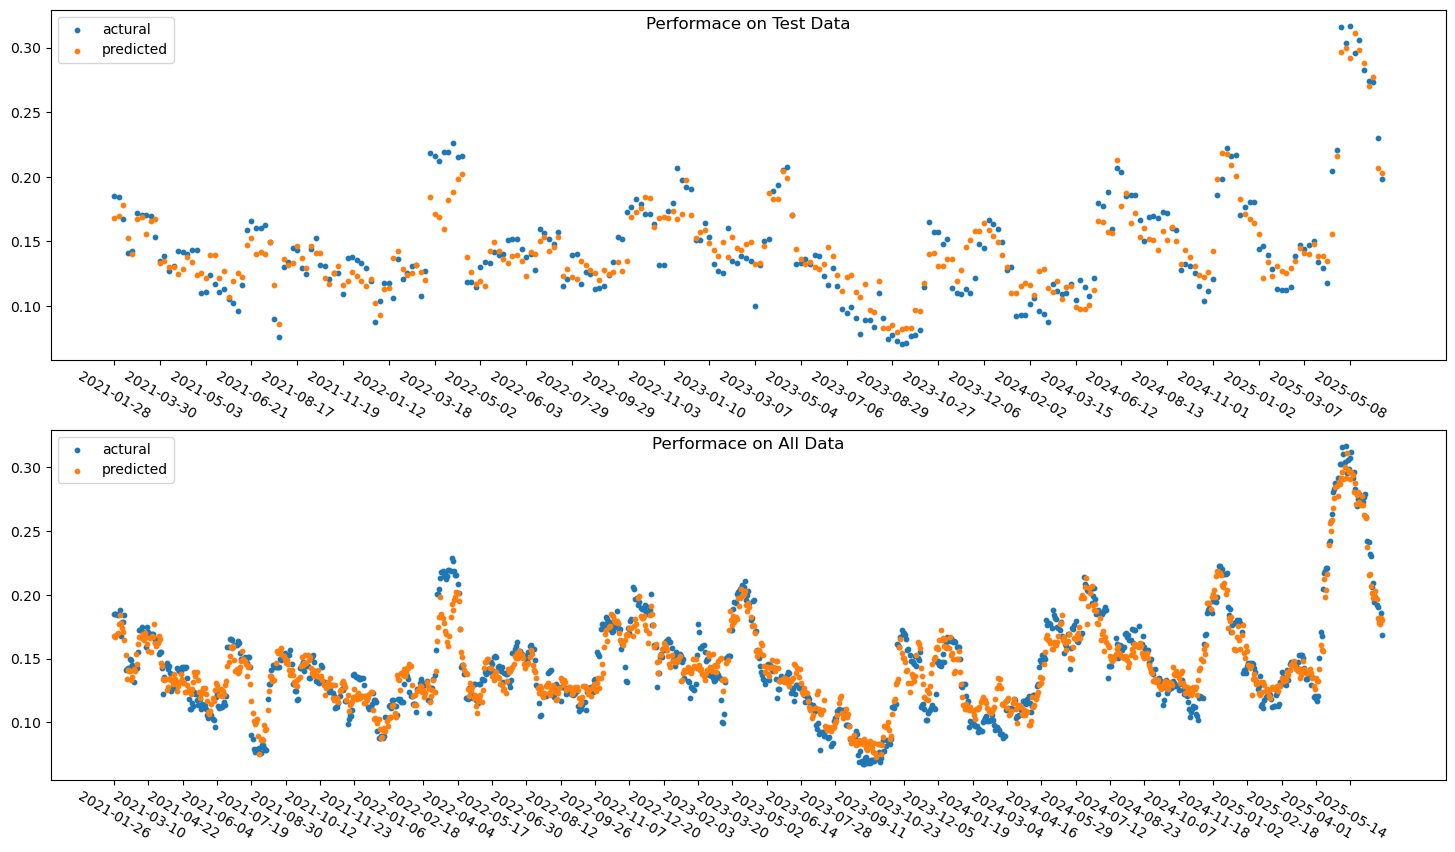

In [51]:
plot_performance_test_all_data(y_merged_test_df, y_merged_all_df)

Plot models performance

In [94]:
# trial_performance_df.to_excel(f'./vol_output/trial_performance_{datetime.today().date()}.xlsx')


Predict on lastest data

In [ ]:
from pandas.tseries.offsets import BDay
from vol_predict import VolPredictor

DAYS_WINDOW_SIZE = 21
SEQUENCE_LENGTH_WINDOWS = 6
ticker = 'GLD'
saved_scaler = joblib.load(scaler_path)

# Suppose the last date in the data retrieved for training is the current date
current_date = vol_data['Date'].max()
target_date = (current_date + BDay(DAYS_WINDOW_SIZE)).date()

vol_predictor = VolPredictor()
num_samples = DAYS_WINDOW_SIZE * (SEQUENCE_LENGTH_WINDOWS-1) + 1

feature_cols = [col for col in vol_data.columns if col.startswith(vol_predictor._FEATURE_PREFIX)]
pred_feature_data_array = vol_data[feature_cols].iloc[:num_samples].values
X_pred = vol_predictor.restruncture_data(pred_feature_data_array, vol_window_days=DAYS_WINDOW_SIZE, sequence_months=SEQUENCE_LENGTH_WINDOWS)[-1]

ensemble_preds_df = ensemble_prediction(selected_models, X_pred.reshape(1,SEQUENCE_LENGTH_WINDOWS,len(col_names)), target_date)
rv_pred = ensemble_preds_df.iloc[:,1:].mean(axis=1)
rv_inver_pred = (rv_pred - saved_scaler.min_[target_feature_index]) / saved_scaler.scale_[target_feature_index]
# print(X_pred)
print(f'target date: {target_date}')
print(f'scaled prediction: {rv_pred}')
print(f'invert prediction: {rv_inver_pred}')

target date: 2025-07-24
scaled prediction: 0    0.400716
dtype: float32
invert prediction: 0    0.167392
dtype: float32


Get corresponding Implied Vol

In [ ]:
from pandas.tseries.offsets import BDay
import iv_helper 
from importlib import reload
reload(iv_helper)

ticker = 'GLD'

asset = iv_helper.get_asset(ticker)
market_price = iv_helper.get_asset_price_for_given_date(asset, current_date)
iv = iv_helper.get_implied_vol(asset, market_price, target_date)

In [93]:
print(f'Implied Vol: {iv:.4f}, Realised Vol: {rv_inver_pred[0]:.4f}')

Implied Vol: 0.1790, Realised Vol: 0.1674


Strategy 

if iv - rv > threshold:
    sell straddle -- to earn premium
                     expecting market overestimate volatililty
                     the asset price stays small movement and both options expire worthless
                     if asset price move a lot, the losses can be large. price increase can be unlimited

if iv - rv < -threshold:
    buy straddle --  to earn one leg of the straddle profit
                     expecting market is underestimating volatility 
                     the asset price will move a lot and one leg of straddle profit
                     if asset price stays flat, the lossees will be premiums of both options
                            